##GENDER INCOME GAP

you may know that it is estimated that women earn about 78% of men in the same job position. 
Can we test that on NYC income data? Can we turn that into a prediction: if you get hired at a certain stipend as a men, what should you expect to make as a woman? (or from the point of view of a job employer, perhaps not one with a very strong moral compass, what should I offer a woman job candidate, given what I would offer a man for the same job?)




In [1]:
import pandas as pd
import sys
import os
import numpy 
import pylab as pl
import xlrd
import statsmodels.formula.api as smf
import scipy.stats as stats

import json
import os

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#The gender gap(non mandatory viewing)
from IPython.display import YouTubeVideo
YouTubeVideo("G_ikzQM93W8")

the Census data on income
http://www.census.gov/hhes/www/cpstables/032015/perinc/pinc03_000.htm

unfortunately a lot of the links that i originally used a few weeks ago are broken now. I posted the data I had used on the class webpage here (together with data for the buildings & energy homework): http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data

In [3]:
#to use the url just pass it to pandas read_excel
url="http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/"
#split your data by male and female, for example you can load the data into 2 dictionary. other variables may be relevant: for example race.
#the names are not informative, and i am not giving you any meta data to find out what is in each file. 
# 08_2 files are male, 08_3 are female, and I am leaving in the lines of code that read the male files into races

allmales={}
allfemales={}
allmales['all']=pd.read_excel(url+'/pinc08_2_1_1.xls',header=9)#%s/pinc03_2_1_1.xls'%url, header=9)
allmales['white']=pd.read_excel(url+'/pinc08_2_1_4.xls', header=9)
allmales['black']=pd.read_excel(url+'/pinc08_2_1_6.xls', header=9)
allmales['hispanic']=pd.read_excel(url+'/pinc08_2_1_9.xls', header=9)
allmales['asian']=pd.read_excel(url+'/pinc08_2_1_8.xls', header=9)

In [4]:
allfemales['all']=pd.read_excel(url+'/pinc08_3_1_1.xls', header=9)
allfemales['white']=pd.read_excel(url+'/pinc08_3_1_4.xls', header=9)
allfemales['black']=pd.read_excel(url+'/pinc08_3_1_6.xls', header=9)
allfemales['hispanic']=pd.read_excel(url+'/pinc08_3_1_9.xls', header=9)
allfemales['asian']=pd.read_excel(url+'/pinc08_3_1_8.xls', header=9)

##exploratory phase

In [5]:
#let's see what is in the data
from pandas.tools.plotting import scatter_matrix
#scatter_matrix(...

#like for the building homework: this fails cause the data is not parsed and formatted propoerly
#so maybe just print the columns to find out
for pop in allmales:
    allmales[pop].columns = allmales[pop].columns.str.replace('[$,: ]', '')
    allfemales[pop].columns = allfemales[pop].columns.str.replace('[$,: ]', '')

In [6]:
#Another way to remove non real entries, is to use the np.isreal command, 
#i end up doing it in a for loop, which is ugly.
#think about how you could improve on that if you already have coding experience
#and are used to pythonic ways!

for k in allmales:
    nonreal  = allmales[k].applymap(np.isreal)
    for c in allmales[k].columns:
        if nonreal.sum()[c]>1 and nonreal.sum()[c]<49:
            allmales[k][c][~nonreal[c]] = np.float('NaN')
            allmales[k][c] = allmales[k][c].astype(float)

    

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


now you can try again with the scatter matrix and see if there are any insightful correlations. 
please  make and comment the plot


In [7]:
#do the same for females

for k in allfemales:
    nonreal  = allfemales[k].applymap(np.isreal)
    for c in allfemales[k].columns:
        if nonreal.sum()[c]>1 and nonreal.sum()[c]<49:
            allfemales[k][c][~nonreal[c]] = np.float('NaN')
            allfemales[k][c] = allfemales[k][c].astype(float) 

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ee33e10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10efa5850>, ...,
        <matplotlib.axes._subplots.AxesSubplot object at 0x110e22050>, ...,
        <matplotlib.axes._subplots.AxesSubplot object at 0x112453ed0>, ...,
       ..., 
        <matplotlib.axes._subplots.AxesSubplot object at 0x14e87bb90>, ...,
        <matplotlib.axes._subplots.AxesSubplot object at 0x14fdcf250>, ...,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1514116d0>, ...,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1528ee910>]], dtype=object)

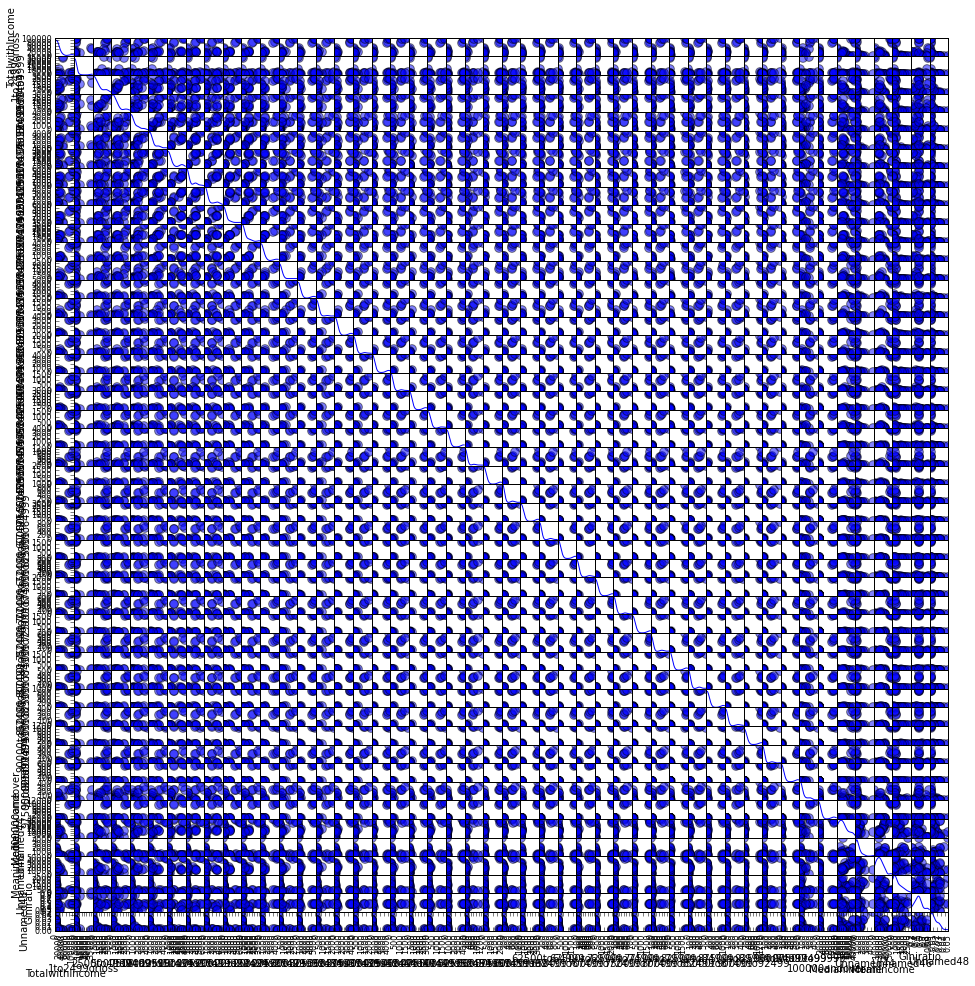

In [8]:
# scatter matrix for all males (all)... this is crazy (too many features to be helpful)
scatter_matrix (allmales['all'], s=300, figsize=(16, 16), diagonal='kde')

In [11]:
# # scatter matrix for all females (all)
# scatter_matrix (allfemales['all'], s=300, figsize=(16, 16), diagonal='kde')

##to see how the male and female income relate to each other plot the Total Median Income (from any source of revenue) of females vs the Total Median Income of males by race (one data point per race)

##also plot the 1-1 line: the diagonal that corresponds to men and women getting the same pay
(make the plot and describe it in a "caption" in the cell below the plot)

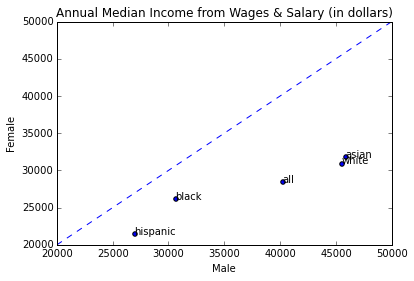

In [12]:
# I selected to look at Wages and Salary as the source of revenue for this analysis

df = pd.DataFrame(columns=['pop', 'medinc_male', 'medinc_female'])
#print df.head()

for pop in allmales:
    a = pop
    b = allmales[pop]['Medianincome'] [allmales[pop]['Characteristic'] == u'..Wages and Salary']
    c = allfemales[pop]['Medianincome'] [allfemales[pop]['Characteristic'] == u'..Wages and Salary']
    df.loc[len(df)] = [a, b.values[0], c.values[0]]
#print df

pl.scatter(df['medinc_male'], df['medinc_female'])
pl.xlim(20000,50000)
pl.ylim(20000,50000)
pl.xlabel('Male')
pl.ylabel('Female')

for i, txt in enumerate(df['pop']):
    pl.annotate(txt, (df['medinc_male'][i], df['medinc_female'][i]))

pl.plot([20000, 50000], [20000, 50000], ls="--")

pl.title('Annual Median Income from Wages & Salary (in dollars)')
pl.show()

#Now fit it with a line!
you can use statsmodels, or scipy, numpy, or create your own residual minimization function. 
if you want to use numpy (and you do not have to!) you can for example use 


pl.plot(newx,np.poly1d(np.ployfit(x,y,1))(newx)

to make and plot the fit in one line (although this way you did not save the parameters so you need to rerun the function to get the slope and intercept ... :-/

why not challenge yourself (if you want) and  create your own residual minimization function you can minimize it with scipy instead of a nested for loop (which is called 'brute force minimization')

from scipy.optimize import minimize

def line ().....
    #this would be a function that creates a line given parameters, like we did in class
    ...
    return y
def residuals(data, model, error=None):
    #you can add errors if you want
    you want to return the sum of the residuals (difference b/w data and model **2)
    return residuals

you need an initial guess for the parameters, where you start searching. it has to be a single variable, so for 2 parameters make a list of 2 elements. the numbers inside do not have to be 0 and 1 - but choose something not too crazy or your minimization will get lost!

p0 = [0,1] 

result = minimize(residuals, p0, args=(all_males, all_females))

in args i put all arguments of the function residuals that are not to be evaluated for the minimization (in this case the data)

                            OLS Regression Results                            
Dep. Variable:          medinc_female   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     36.94
Date:                Sun, 18 Oct 2015   Prob (F-statistic):            0.00894
Time:                        22:38:02   Log-Likelihood:                -41.744
No. Observations:                   5   AIC:                             87.49
Df Residuals:                       3   BIC:                             86.71
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    1.017e+04   2949.656      3.449      

/usr/local/lib/python2.7/site-packages/statsmodels-0.6.1-py2.7-macosx-10.10-x86_64.egg/statsmodels/stats/stattools.py:72: UserWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n))


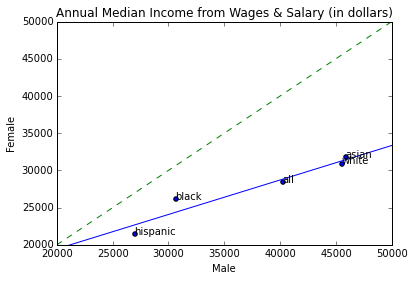

In [13]:
#fit and plot heres
mod = smf.ols('medinc_female ~ medinc_male', data = df).fit()
#print mod.params
print mod.summary()

pl.scatter(df['medinc_male'], df['medinc_female'])
pl.xlim(20000,50000)
pl.ylim(20000,50000)
pl.xlabel('Male')
pl.ylabel('Female')

for i, txt in enumerate(df['pop']):
    pl.annotate(txt, (df['medinc_male'][i], df['medinc_female'][i]))

pl.plot([20000, 50000], [20000, 50000], ls="--", color = 'green')

pl.title('Annual Median Income from Wages & Salary (in dollars)')

X_plot = np.linspace(20000,50000,5000)
pl.plot(X_plot, X_plot*mod.params[1] + mod.params[0])

pl.show()

##it turns out that there is an analytical solution for the OLS regression it is coded below. please try to read the code and understand the formula! 


In [14]:
#this is the analytical best regression line. it can be proved (ask me about it if you want!)
all_males = df['medinc_male']
all_females = df['medinc_female']

cor = stats.spearmanr(all_males, all_females)
all_males.std()/all_females.std()
beta1=cor[0]*all_females.std()/all_males.std()
beta0=all_females.mean()-beta1*all_males.mean()

print beta0, beta1


9475.12441489 0.481904846445


##and plot the line corresponding to the analytical regression to compare it with the result of your numerical one

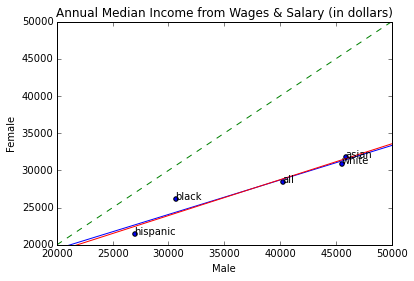

In [15]:
pl.scatter(df['medinc_male'], df['medinc_female'])
pl.xlim(20000,50000)
pl.ylim(20000,50000)
pl.xlabel('Male')
pl.ylabel('Female')

for i, txt in enumerate(df['pop']):
    pl.annotate(txt, (df['medinc_male'][i], df['medinc_female'][i]))

pl.plot([20000, 50000], [20000, 50000], ls="--", color = 'green')

pl.title('Annual Median Income from Wages & Salary (in dollars)')

pl.plot(X_plot, X_plot*mod.params[1] + mod.params[0], color = 'blue')

pl.plot(X_plot, X_plot*beta1 + beta0, color = 'red') #this is the analytical soln
pl.show()


#this was done with THE TOTAL MEDIAN INCOME, let's now see if all forms of income lead to a different fit. 

if you use one data point for source of income (along the 'Median income' column) and fit a line and the line fit is similar then the median income was representative fo all forms of income for this analysis

to unravel the data and concatenate them back together in a single array is a little complex (there may be easier way, this is just wha i came up with. if you have something better please share!!)
here ar a few lines of code that should do the trick. i used nu.concatenate to put together arrays (it takes a list of arrays) and np.flatten to make the array 1 dimensional after merging. i also masked the nan values. i used the numpy ma (masled array) package. ever array is associated by this package to a mask array of Bools [True....False...] of the same size. the 

In [16]:
all_males=np.ma.array(np.concatenate([allmales['all']['Medianincome'][:].values,allmales['white']['Medianincome'][:].values,allmales['black']['Medianincome'][:].values,allmales['hispanic']['Medianincome'][:].values,allmales['asian']['Medianincome'][:].values]).flatten())
all_females=np.ma.array(np.concatenate([allfemales['all']['Medianincome'][:].values,allfemales['white']['Medianincome'][:].values,allfemales['black']['Medianincome'][:].values,allfemales['hispanic']['Medianincome'][:].values,allfemales['asian']['Medianincome'][:].values]).flatten())

#I am gonna create the mask int he next line. 
#the mask is True where either male or female value is Nan. 
#Notice that True is really just >1, and False really 0. 
#so i can add the male and female mask and the resulting mask will be 
#False where both arrays are not Nan, and true otherwise. 

allmask = [np.isnan(all_males) + np.isnan(all_females)]

all_females.mask = allmask
all_males.mask = allmask

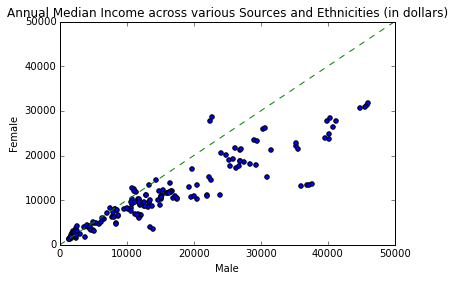

In [17]:
#fit and plot [...]
pl.scatter(all_males[~all_males.mask], all_females[~all_females.mask])
pl.xlim(0,50000)
pl.ylim(0,50000)
pl.xlabel('Male')
pl.ylabel('Female')

pl.plot([0, 50000], [0, 50000], ls="--", color = 'green')

pl.title('Annual Median Income across various Sources and Ethnicities (in dollars)')



In [18]:
#is the line fit similar? can you find any high legverage points?
df2 = pd.DataFrame({})
df2['x'] = all_males[~all_males.mask]
df2['y'] = all_females[~all_females.mask]

mod2 = smf.ols('y~x', data = df2).fit()
print mod2.summary()

# The line fit is similar in direction and general magnitude. There are some high leverage points at higher income
# levels for male.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     1075.
Date:                Sun, 18 Oct 2015   Prob (F-statistic):           7.21e-77
Time:                        22:38:09   Log-Likelihood:                -1668.8
No. Observations:                 178   AIC:                             3342.
Df Residuals:                     176   BIC:                             3348.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1493.0394    351.359      4.249      0.0

##Now pick a stipend, maybe your ideal stipend? 
##and predict what a woman in a position where a man recieves your ideal stipend would make



In [19]:
# My ideal stipend is $100,000. 
print '$ {0:.2f}'.format(mod2.params[0] + mod2.params[1]*100000)

# A woman in a position where a man receives my ideal stipend would make $62,395.

$ 62395.09


##lastly do you have any comments about what these data tell us about race? how you would go about analyzing race differences with these data? (just a few sentences)

In [20]:
# These data tell us that there appears to be a relationship between race and income also. 

# In order to do a basic analysis on this, I would like to have additional data on educational attainment, years of work
# experience, industry, etc. to make income more comparable. I would include these factors in the model.

# If the given data is all that is available, I would perform an analysis to that done for gender where I would make
# race a categorical variable with 'all' being the default for comparison. 

